In [1]:
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from citeline.database.milvusdb import MilvusDB
from citeline.embedders import Embedder
from citeline.query_expander import get_expander

db = MilvusDB()
print(db)

tqdm.pandas()

# Setup: load embedder, expander, dataset, db collection
embedder = Embedder.create("Qwen/Qwen3-Embedding-0.6B", device="mps", normalize=True)
print(embedder)

expander = get_expander("add_prev_3", path_to_data="../data/preprocessed/reviews.jsonl")
print(expander)

sample = pd.read_json("../data/dataset/nontrivial_nomath.jsonl", lines=True)
sample = sample.sample(20, random_state=42).reset_index(drop=True)

# Apply query expansion and embed the queries
sample["sent_no_cit"] = expander(sample)
sample["vector"] = sample.progress_apply(lambda row: embedder([row["sent_no_cit"]])[0], axis=1)

db.list_collections()
db.client.load_collection("qwen06_contributions")

sample.head()

Qwen/Qwen3-Embedding-0.6B, device=mps, normalize=True, dim=1024
QueryExpander(name=add_prev_3, data_length=2980)


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]

Collections:
 - astrobert_chunks: 460801 entities
 - astrobert_contributions: 89860 entities
 - bge_chunks: 460801 entities
 - bge_contributions: 89860 entities
 - nasa_chunks: 460801 entities
 - nasa_contributions: 89860 entities
 - qwen06_chunks: 460801 entities
 - qwen06_contributions: 89860 entities
 - qwen06_findings_v2: 4342 entities
 - qwen8b_contributions: 89860 entities
 - specter_chunks: 460801 entities
 - specter_contributions: 89860 entities


,source_doi,sent_original,sent_no_cit,sent_idx,citation_dois,pubdate,resolved_bibcodes,sent_cit_masked,vector
0,10.1146/annurev-astro-021022-043545,"For example, strong outliers from the MZR with...",There are important practical implications for...,494,[10.1088/0004-637X/695/1/259],20220801,[2009ApJ...695..259P],"For example, strong outliers from the MZR with...","[-0.0304536, -0.03546455, -0.008876894, -0.028..."
1,10.1007/s001590050008,Grillmair et al. (1995a) conclude that the sta...,They find that most of their sample clusters s...,593,[10.1086/117470],19970101,[1995AJ....109.2553G],[REF] conclude that the stars found beyond the...,"[-0.023469558, 0.0036594549, -0.009580555, 0.0..."
2,10.1016/j.newar.2021.101610,"Later, a very similar study was carried out by...","For the problem at hand, these conditions are ...",608,[10.1111/j.1365-2966.2010.17674.x],20210601,[2011MNRAS.411..155G],"Later, a very similar study was carried out by...","[0.012016729, -0.036106728, -0.008817904, 0.02..."
3,10.1146/annurev-astro-082214-122348,k Using column density of C-C bonds derived by...,h Identification based on a single absorption ...,377,[10.1088/0004-637X/784/2/172],20150801,[2014ApJ...784..172H],k Using column density of C-C bonds derived by...,"[-0.05986425, -0.016321747, -0.008735628, 0.01..."
4,10.1146/annurev.astro.41.082801.100328,One of the most surprising observations to dat...,Additional evidence for clumpiness comes from ...,321,[10.1086/319733],20030101,[2001ApJ...550..142H],One of the most surprising observations to dat...,"[-0.0136848325, -0.06581634, -0.010353548, 0.0..."


In [36]:
research = pd.read_json('../data/research_used.jsonl', lines=True)

In [44]:
for idx, row in research.iterrows():
    authors = row.author
    if any(['Kart' in name for name in authors]):
        print(row.pubdate, row.doi, row.title, authors)

2003-04-01 10.1086/346076 The BIMA Survey of Nearby Galaxies (BIMA SONG). II. The CO Data ['Helfer, Tamara T.', 'Thornley, Michele D.', 'Regan, Michael W.', 'Wong, Tony', 'Sheth, Kartik', 'Vogel, Stuart N.', 'Blitz, Leo', 'Bock, Douglas C. -J.']
1999-03-01 10.1086/306824 Megamaser Disks in Active Galactic Nuclei ['Kartje, John F.', 'Königl, Arieh', 'Elitzur, Moshe']
2015-05-01 10.1088/2041-8205/804/1/L21 Small Scatter and Nearly Isothermal Mass Profiles to Four Half-light Radii from Two-dimensional Stellar Dynamics of Early-type Galaxies ['Cappellari, Michele', 'Romanowsky, Aaron J.', 'Brodie, Jean P.', 'Forbes, Duncan A.', 'Strader, Jay', 'Foster, Caroline', 'Kartha, Sreeja S.', 'Pastorello, Nicola', 'Pota, Vincenzo', 'Spitler, Lee R.', 'Usher, Christopher', 'Arnold, Jacob A.']
2012-07-01 10.1088/0004-637X/753/2/167 What Turns Galaxies Off? The Different Morphologies of Star-forming and Quiescent Galaxies since z ~ 2 from CANDELS ['Bell, Eric F.', 'van der Wel, Arjen', 'Papovich, Case

In [31]:
# Data patches

# one sample has incorrect citation_dois
sample.at[15, "citation_dois"] = ["10.48550/arXiv.1110.4057"]

In [35]:
print(db.select_by_doi(doi="10.1088/0004-637X/757/1/23", collection_name="qwen06_contributions"))

Empty DataFrame
Columns: []
Index: []


In [32]:
def get_hard_records(example: pd.Series, n: int = 2) -> list[str]:
    """
    Overfetches 3*n most similar records (bc if two reps from same doc are in top n, we won't have n distinct non-target dois)

    Returns:
      A list of doi's, ordered by their max similarity to the query
    """
    results = db.search(
        collection_name="qwen06_contributions",
        query_records=[example.to_dict()],
        query_vectors=[example.vector],
        limit=3 * n,
    )
    results = results[0]  # db.search operates on lists of queries; we only need the first result

    # Filter results to non-targets only
    target_dois = set(example.citation_dois)
    non_target_results = [r for r in results if r["doi"] not in target_dois]
    return non_target_results[:n]


def get_similarity_to_targets(example: pd.Series) -> list[float]:
    """
    For each target doi in the example, computes the max similarity between the example and any record with that doi.

    Returns a list of scores in order of example.citation_dois
    """
    similarities = []
    for target_doi in example.citation_dois:
        results = db.select_by_doi(doi=target_doi, collection_name="qwen06_contributions")
        target_vectors = np.array(results["vector"].tolist())
        similarity_scores = np.dot(example.vector, target_vectors.T)
        similarities.append(np.max(similarity_scores))
    return similarities


def compute_margins(df: pd.DataFrame, target_col: str, hard_col: str, margin_col_name: str) -> None:
    """
    For each row in the DataFrame, computes the margin between each target similarity and the hardest non-target similarity.

    Args:
      df: DataFrame containing the data
      target_col: Name of the column with list of target similarities
      hard_col: Name of the column with list of hard non-target similarities
      margin_col_name: Name of the column to store the computed margins

    Returns:
      None (modifies df in place)
    """
    df[margin_col_name] = None
    for idx, row in df.iterrows():
        target_similarities = row[target_col]
        hardest_nontarget_similarity = max(row[hard_col])
        margins = [target_sim - hardest_nontarget_similarity for target_sim in target_similarities]
        df.at[idx, margin_col_name] = margins


# Compute target and hard similarities, then the margins
sample["target_similarities"] = sample.progress_apply(get_similarity_to_targets, axis=1)
sample["hard_dois"] = None
sample["hard_similarities"] = None
for idx, example in tqdm(sample.iterrows(), total=len(sample)):
    hard_records = get_hard_records(example, n=2)
    sample.at[idx, "hard_dois"] = [r["doi"] for r in hard_records]
    sample.at[idx, "hard_similarities"] = [r["metric"] for r in hard_records]

compute_margins(sample, target_col="target_similarities", hard_col="hard_similarities", margin_col_name="old_margins")

 80%|████████  | 16/20 [00:00<00:00, 172.10it/s]


KeyError: 'vector'

In [3]:
margins = pd.to_numeric(sample.explode(column="old_margins")["old_margins"], errors="coerce").dropna()
margins.describe()

count    25.000000
mean     -0.047545
std       0.079395
min      -0.174869
25%      -0.103946
50%      -0.058428
75%      -0.008044
max       0.163279
Name: old_margins, dtype: float64

## Process the dois


In [4]:
dois_to_process = set(doi for dois in sample.citation_dois for doi in dois).union(
    doi for dois in sample.hard_dois for doi in dois
)
print(f"DOI's to process: {len(dois_to_process)}")

# Load research papers so we can get full text by doi
research = pd.read_json("../data/research_used.jsonl", lines=True)
research = research[research["doi"].isin(dois_to_process)].reset_index(drop=True)
print(f"Loaded {len(research)} research papers")


def doi_to_paper(doi: str) -> str:
    record = research[research["doi"] == doi].iloc[0]
    return record["title"] + "\n\n" + record["abstract"] + "\n\n" + record["body"]


# Test:
doi = list(dois_to_process)[0]
print(doi_to_paper(doi)[:500])

DOI's to process: 60
Loaded 60 research papers
Observations of the Hubble Deep Field with the Infrared Space Observatory - V. Spectral energy distributions, starburst models and star formation history

We have modelled the spectral energy distributions of the 13 Hubble Deep Field (HDF) galaxies reliably detected by the Infrared Space Observatory (ISO). For two galaxies the emission detected by ISO is consistent with being starlight or the infrared `cirrus' in the galaxies. For the remaining 11 galaxies there is a clear mid-infrared excess, w


In [6]:
from openai import OpenAI
import os


def bind_client(func):
    """
    Decorator to bind OpenAI client to a function that will provide DeepSeek API access
    """
    client = OpenAI(api_key=os.getenv("DEEPSEEK_API_KEY"), base_url="https://api.deepseek.com")

    def wrapper(*args, **kwargs):
        return func(client, *args, **kwargs)

    return wrapper


@bind_client
def deepseek(client, prompt: str) -> str:
    """
    Sends a prompt to the DeepSeek API (using DeepSeek-V3.1 non-thinking model)

    Expects a prompt that will instruct the model to respond with a JSON object.
    However, the function returns the raw string response, to allow for validation and
    error handling in multiple passes without losing the original response
    """
    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[{"role": "system", "content": prompt}],
        stream=False,
        response_format={"type": "json_object"},
    )
    return response.choices[0].message.content


response = deepseek("Respond with a JSON object with keys 'greeting' and 'farewell'")
print(response)
print(json.loads(response))

{
  "greeting": "Hello!",
  "farewell": "Goodbye!"
}
{'greeting': 'Hello!', 'farewell': 'Goodbye!'}


In [ ]:
from citeline.apis.openai_client import openai_llm_client

openai_llm = openai_llm_client(model="gpt-5-nano")

In [ ]:
from google import genai
from google.genai import types
from citeline.llm.models import Findings

client = genai.Client()
with open("../src/citeline/llm/prompts/original_contributions_gemini_v3.txt", "r") as f:
    prompt_template = f.read()


def gemini(paper: str) -> str:
    raw_text = ""
    try:
        response = client.models.generate_content(
            model="gemini-2.5-flash",
            config=types.GenerateContentConfig(
                temperature=0.0,
                system_instruction=prompt_template,
                response_mime_type="application/json",
                response_schema=Findings,
            ),
            contents=paper,
        )
        return response.parsed
    except Exception as e:
        print(f"Error during Gemini call: {e}")
        return ""

In [7]:
with open("../src/citeline/llm/prompts/original_contributions_v3.txt", "r") as f:
    prompt_template = f.read()

llm_function = deepseek
# llm_function = openai_llm

with open("new_findings.jsonl", "w") as f:
    for doi in tqdm(dois_to_process):
        paper = doi_to_paper(doi)
        prompt = prompt_template.format(paper=paper)
        try:
            response = llm_function(prompt)
        except Exception as e:
            print(f"Error processing doi {doi}: {e}")
            continue
        try:
            data = json.loads(response)
            data["doi"] = doi
            f.write(json.dumps(data) + "\n")
        except json.JSONDecodeError:
            print(f"Failed to decode JSON for doi {doi}. Response was:\n{response}")
            with open("failed_dois.txt", "a") as f_fail:
                f_fail.write(doi + "\n")
            continue

100%|██████████| 60/60 [35:07<00:00, 35.12s/it]


In [8]:
new_findings = pd.read_json("new_findings.jsonl", lines=True)
print(f"Loaded {len(new_findings)} new findings")

new_findings_exploded = new_findings.explode("findings")
new_findings_exploded["vector"] = embedder(new_findings_exploded["findings"].tolist()).tolist()
new_findings_exploded.head()

Loaded 60 new findings


,findings,doi,vector
0,Infrared Space Observatory (ISO) detected 13 g...,10.1093/mnras/289.2.490,"[-0.03467569500207901, -0.01793549209833145, -..."
0,"For 2 of 13 ISO-detected HDF galaxies, the inf...",10.1093/mnras/289.2.490,"[-0.00321136973798275, 0.0041879769414663315, ..."
0,"For 11 of 13 ISO-detected HDF galaxies, there ...",10.1093/mnras/289.2.490,"[-0.03414859250187874, -0.013239392079412937, ..."
0,10 of the 11 starburst galaxies detected by IS...,10.1093/mnras/289.2.490,"[0.02837005816400051, -0.04323531687259674, -0..."
0,One of the 11 starburst galaxies detected by I...,10.1093/mnras/289.2.490,"[0.006827202159911394, 0.008716949261724949, -..."


In [ ]:
# Get new similarity to target
sample["new_target_similarities"] = None
sample["new_hard_similarities"] = None


def get_vectors_by_doi(doi: str) -> np.ndarray:
    return np.array(new_findings_exploded[new_findings_exploded["doi"] == doi]["vector"].tolist())


for idx, row in sample.iterrows():
    # For each target doi, compute the max similarity wrt the new embeddings
    query_vector = row["vector"]
    new_similarities = []
    for target_doi in row["citation_dois"]:
        target_vectors = get_vectors_by_doi(target_doi)
        new_similarities.append(np.max(np.dot(query_vector, target_vectors.T)))
    sample.at[idx, "new_target_similarities"] = new_similarities

    # Collect all the hard vectors, compute the hard similarities
    new_hard_similarities = []
    for doi in row["hard_dois"]:
        candidate_vectors = get_vectors_by_doi(doi)
        new_hard_similarities.append(np.max(np.dot(query_vector, candidate_vectors.T)))
    sample.at[idx, "new_hard_similarities"] = new_hard_similarities

,source_doi,sent_original,sent_no_cit,sent_idx,citation_dois,pubdate,resolved_bibcodes,sent_cit_masked,vector,target_similarities,hard_dois,hard_similarities,old_margins,new_target_similarities,new_hard_similarities
0,10.1146/annurev-astro-021022-043545,"For example, strong outliers from the MZR with...",There are important practical implications for...,494,[10.1088/0004-637X/695/1/259],20220801,[2009ApJ...695..259P],"For example, strong outliers from the MZR with...","[-0.0304536, -0.03546455, -0.008876894, -0.028...",[0.6714103423488335],"[10.1093/mnras/stz243, 10.1093/mnras/stz243]","[0.7405368685722351, 0.7342004776000977]",[-0.06912652622340165],[0.6955648445807845],"[0.7494102275258021, 0.7494102275258021]"
1,10.1007/s001590050008,Grillmair et al. (1995a) conclude that the sta...,They find that most of their sample clusters s...,593,[10.1086/117470],19970101,[1995AJ....109.2553G],[REF] conclude that the stars found beyond the...,"[-0.023469558, 0.0036594549, -0.009580555, 0.0...",[0.8223601027642284],[10.1093/mnras/255.3.389],[0.6590808629989624],[0.16327923976526604],[0.8156744325091434],[0.6568489190290248]
2,10.1016/j.newar.2021.101610,"Later, a very similar study was carried out by...","For the problem at hand, these conditions are ...",608,[10.1111/j.1365-2966.2010.17674.x],20210601,[2011MNRAS.411..155G],"Later, a very similar study was carried out by...","[0.012016729, -0.036106728, -0.008817904, 0.02...",[0.5592305490814439],"[10.1111/j.1365-2966.2007.12050.x, 10.1046/j.1...","[0.6205031871795654, 0.6167439818382263]",[-0.06127263809812156],[0.5536569231450893],"[0.5859291273958447, 0.5614774331584942]"
3,10.1146/annurev-astro-082214-122348,k Using column density of C-C bonds derived by...,h Identification based on a single absorption ...,377,[10.1088/0004-637X/784/2/172],20150801,[2014ApJ...784..172H],k Using column density of C-C bonds derived by...,"[-0.05986425, -0.016321747, -0.008735628, 0.01...",[0.6608908641351936],"[10.1086/173362, 10.1111/j.1365-2966.2004.0803...","[0.6945939660072327, 0.6876973509788513]",[-0.033703101872039065],[0.6877965988299924],"[0.7085189291220004, 0.6335521527231314]"
4,10.1146/annurev.astro.41.082801.100328,One of the most surprising observations to dat...,Additional evidence for clumpiness comes from ...,321,[10.1086/319733],20030101,[2001ApJ...550..142H],One of the most surprising observations to dat...,"[-0.0136848325, -0.06581634, -0.010353548, 0.0...",[0.5935789034305913],"[10.1086/345096, 10.48550/arXiv.astro-ph/9902070]","[0.6975250840187073, 0.6517747640609741]",[-0.103946180588116],[0.585297836239575],"[0.6661234089551791, 0.6052471131293904]"


In [ ]:
compute_margins(
    sample, target_col="new_target_similarities", hard_col="new_hard_similarities", margin_col_name="new_margins"
)

,source_doi,sent_original,sent_no_cit,sent_idx,citation_dois,pubdate,resolved_bibcodes,sent_cit_masked,vector,target_similarities,hard_dois,hard_similarities,old_margins,new_target_similarities,new_hard_similarities,new_margins
0,10.1146/annurev-astro-021022-043545,"For example, strong outliers from the MZR with...",There are important practical implications for...,494,[10.1088/0004-637X/695/1/259],20220801,[2009ApJ...695..259P],"For example, strong outliers from the MZR with...","[-0.0304536, -0.03546455, -0.008876894, -0.028...",[0.6714103423488335],"[10.1093/mnras/stz243, 10.1093/mnras/stz243]","[0.7405368685722351, 0.7342004776000977]",[-0.06912652622340165],[0.6955648445807845],"[0.7494102275258021, 0.7494102275258021]",[-0.05384538294501762]
1,10.1007/s001590050008,Grillmair et al. (1995a) conclude that the sta...,They find that most of their sample clusters s...,593,[10.1086/117470],19970101,[1995AJ....109.2553G],[REF] conclude that the stars found beyond the...,"[-0.023469558, 0.0036594549, -0.009580555, 0.0...",[0.8223601027642284],[10.1093/mnras/255.3.389],[0.6590808629989624],[0.16327923976526604],[0.8156744325091434],[0.6568489190290248],[0.15882551348011864]
2,10.1016/j.newar.2021.101610,"Later, a very similar study was carried out by...","For the problem at hand, these conditions are ...",608,[10.1111/j.1365-2966.2010.17674.x],20210601,[2011MNRAS.411..155G],"Later, a very similar study was carried out by...","[0.012016729, -0.036106728, -0.008817904, 0.02...",[0.5592305490814439],"[10.1111/j.1365-2966.2007.12050.x, 10.1046/j.1...","[0.6205031871795654, 0.6167439818382263]",[-0.06127263809812156],[0.5536569231450893],"[0.5859291273958447, 0.5614774331584942]",[-0.03227220425075539]
3,10.1146/annurev-astro-082214-122348,k Using column density of C-C bonds derived by...,h Identification based on a single absorption ...,377,[10.1088/0004-637X/784/2/172],20150801,[2014ApJ...784..172H],k Using column density of C-C bonds derived by...,"[-0.05986425, -0.016321747, -0.008735628, 0.01...",[0.6608908641351936],"[10.1086/173362, 10.1111/j.1365-2966.2004.0803...","[0.6945939660072327, 0.6876973509788513]",[-0.033703101872039065],[0.6877965988299924],"[0.7085189291220004, 0.6335521527231314]",[-0.020722330292007984]
4,10.1146/annurev.astro.41.082801.100328,One of the most surprising observations to dat...,Additional evidence for clumpiness comes from ...,321,[10.1086/319733],20030101,[2001ApJ...550..142H],One of the most surprising observations to dat...,"[-0.0136848325, -0.06581634, -0.010353548, 0.0...",[0.5935789034305913],"[10.1086/345096, 10.48550/arXiv.astro-ph/9902070]","[0.6975250840187073, 0.6517747640609741]",[-0.103946180588116],[0.585297836239575],"[0.6661234089551791, 0.6052471131293904]",[-0.08082557271560409]


In [11]:
def compute_margin_diffs(df: pd.DataFrame, new_col: str, ref_col: str) -> pd.Series:
    new_values = df[new_col].explode().tolist()
    ref_values = df[ref_col].explode().tolist()
    diffs = [new - ref for new, ref in zip(new_values, ref_values)]
    return pd.Series(diffs)


diffs = compute_margin_diffs(sample, new_col="new_margins", ref_col="old_margins")
print(diffs.describe())

count    25.000000
mean      0.027870
std       0.065328
min      -0.070470
25%      -0.004454
50%       0.015281
75%       0.046321
max       0.216250
dtype: float64


<Axes: >

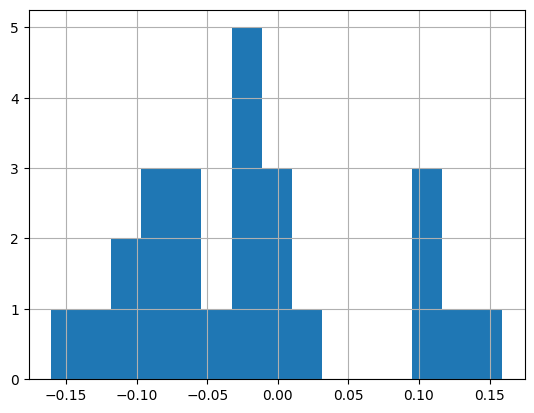

In [19]:
sample['new_margins'].explode().hist(bins=15)

## Error analysis

Let's look at where the new margin is still negative (the target document vectors aren't as close to the query as the hard examples)


In [12]:
error_rows = sample[sample["new_margins"].apply(lambda margins: any(margin < 0 for margin in margins))]
print(f"{len(error_rows)} rows have at least one negative new margin")

error_margins = pd.to_numeric(error_rows.explode(column="new_margins")["new_margins"], errors="coerce").dropna()
print(error_margins.describe())

15 rows have at least one negative new margin
count    17.000000
mean     -0.065361
std       0.043040
min      -0.160494
25%      -0.082666
50%      -0.069430
75%      -0.027933
max      -0.002044
Name: new_margins, dtype: float64


In [21]:
error_rows

,source_doi,sent_original,sent_no_cit,sent_idx,citation_dois,pubdate,resolved_bibcodes,sent_cit_masked,vector,target_similarities,hard_dois,hard_similarities,old_margins,new_target_similarities,new_hard_similarities,new_margins
0,10.1146/annurev-astro-021022-043545,"For example, strong outliers from the MZR with...",There are important practical implications for...,494,[10.1088/0004-637X/695/1/259],20220801,[2009ApJ...695..259P],"For example, strong outliers from the MZR with...","[-0.0304536, -0.03546455, -0.008876894, -0.028...",[0.6714103423488335],"[10.1093/mnras/stz243, 10.1093/mnras/stz243]","[0.7405368685722351, 0.7342004776000977]",[-0.06912652622340165],[0.6955648445807845],"[0.7494102275258021, 0.7494102275258021]",[-0.05384538294501762]
2,10.1016/j.newar.2021.101610,"Later, a very similar study was carried out by...","For the problem at hand, these conditions are ...",608,[10.1111/j.1365-2966.2010.17674.x],20210601,[2011MNRAS.411..155G],"Later, a very similar study was carried out by...","[0.012016729, -0.036106728, -0.008817904, 0.02...",[0.5592305490814439],"[10.1111/j.1365-2966.2007.12050.x, 10.1046/j.1...","[0.6205031871795654, 0.6167439818382263]",[-0.06127263809812156],[0.5536569231450893],"[0.5859291273958447, 0.5614774331584942]",[-0.03227220425075539]
3,10.1146/annurev-astro-082214-122348,k Using column density of C-C bonds derived by...,h Identification based on a single absorption ...,377,[10.1088/0004-637X/784/2/172],20150801,[2014ApJ...784..172H],k Using column density of C-C bonds derived by...,"[-0.05986425, -0.016321747, -0.008735628, 0.01...",[0.6608908641351936],"[10.1086/173362, 10.1111/j.1365-2966.2004.0803...","[0.6945939660072327, 0.6876973509788513]",[-0.033703101872039065],[0.6877965988299924],"[0.7085189291220004, 0.6335521527231314]",[-0.020722330292007984]
4,10.1146/annurev.astro.41.082801.100328,One of the most surprising observations to dat...,Additional evidence for clumpiness comes from ...,321,[10.1086/319733],20030101,[2001ApJ...550..142H],One of the most surprising observations to dat...,"[-0.0136848325, -0.06581634, -0.010353548, 0.0...",[0.5935789034305913],"[10.1086/345096, 10.48550/arXiv.astro-ph/9902070]","[0.6975250840187073, 0.6517747640609741]",[-0.103946180588116],[0.585297836239575],"[0.6661234089551791, 0.6052471131293904]",[-0.08082557271560409]
6,10.1146/annurev.astro.38.1.761,Rowan-Robinson et al (1997) found an even larg...,Most of the background is in sources with 175 ...,686,[10.1093/mnras/289.2.490],20000101,[1997MNRAS.289..490R],[REF] found an even larger correction factor f...,"[0.0076967897, 0.0046737595, -0.011962977, -0....",[0.5817581135359755],"[10.1086/307172, 10.1086/305563]","[0.6783608198165894, 0.671034574508667]",[-0.09660270628061385],[0.6192212541266324],"[0.6886516024102336, 0.6776393003848151]",[-0.06943034828360117]
7,10.1146/annurev-astro-120419-014455,"If this signal is not observed, it implies tha...",Interferometers such as Hydrogen Epoch of Reio...,1069,[10.1038/nature12999],20200801,[2014Natur.506..197F],"If this signal is not observed, it implies tha...","[-0.006658069, -0.00941575, -0.009478936, 0.01...",[0.5910933932256071],"[10.1093/mnras/stu444, 10.1093/mnras/stu444]","[0.6443571448326111, 0.6234678626060486]",[-0.05326375160700403],[0.5892718981534875],"[0.610753292937926, 0.610753292937926]",[-0.021481394784438557]
8,10.1007/s00159-008-0010-0,"(Shang et al. 1998), do show unusual, faint fe...",Such events 123 196 R. Sancisi et al. are more...,159,[10.1086/311563],20080601,[1998ApJ...504L..23S],"([REF]), do show unusual, faint features in th...","[0.019467777, -0.050828665, -0.009596894, 0.01...",[0.5403238222714388],"[10.1086/147890, 10.48550/arXiv.astro-ph/9902227]","[0.6086273193359375, 0.6064630746841431]",[-0.06830349706449867],[0.48558767040371853],"[0.5682540345628277, 0.5352210829771231]",[-0.08266636415910922]
9,10.1146/annurev-astro-052622-031748,Chon et al. (2022) found an opposite trend: in...,This agreement is despite larg

In [78]:
def analyze_error_row(idx: int) -> None:

    example = error_rows.loc[idx]
    margins = [round(float(margin), 4) for margin in example["new_margins"]]
    print(f"Margins: {margins}")
    print("Original sentence:")
    print(example["sent_original"])
    print("\nExpanded sentence:")
    print(example["sent_no_cit"] + "\n")

    hardest_idx = np.argmax(example["new_hard_similarities"])
    hard_doi = example["hard_dois"][hardest_idx]
    hard_findings = new_findings_exploded[new_findings_exploded["doi"] == hard_doi]
    hard_vectors = np.array(hard_findings["vector"].tolist())
    hard_similarities = np.dot(example["vector"], hard_vectors.T)
    hardest_indices = np.argsort(-hard_similarities)[:3]
    for idx in hardest_indices:
        print(f"Similarity: {hard_similarities[idx]:.4f}, DOI: {hard_findings.iloc[idx]['doi']}")
        pprint(hard_findings.iloc[idx]["findings"])
        print("-----")


def print_target_contributions(idx: int) -> None:
    row = error_rows.loc[idx]
    print("Original sentence:")
    print(row["sent_original"])

    target_dois = row["citation_dois"]
    print(f"Target DOIs: {target_dois}")
    target_records = {
        doi: new_findings_exploded[new_findings_exploded["doi"] == doi]["findings"] for doi in target_dois
    }
    pprint("Target findings:")
    for doi in target_records:
        print(f"DOI: {doi}")
        for i, finding in enumerate(target_records[doi]):
            print(f"{i}: {finding}")
        print("-----")


idx = 4

print_target_contributions(idx)
analyze_error_row(idx)

Original sentence:
One of the most surprising observations to date are those of the narrow absorption lines in the quasar 3C 191, which show evidence for partial covering at a large distance (28 kpc) from the nucleus ( Hamann et al. 2001 ); it is difficult to understand how the small clouds have maintained their integrity over the outflow timescale of ∼3 × 10 7 year.
Target DOIs: ['10.1086/319733']
'Target findings:'
DOI: 10.1086/319733
0: Associated absorption lines (AALs) in quasar spectra probe gaseous environments near quasars.
1: High-resolution (6.7 km/s) Keck HIRES spectroscopy measured AALs in radio-loud quasar 3C 191 at redshift z=1.956.
2: AALs in 3C 191 have ionization states ranging from Mg I to N V and multicomponent velocity profiles.
3: AAL profiles in 3C 191 are blueshifted by approximately 400 to 1400 km/s relative to quasar broad emission lines.
4: Excited-state Si II* AAL strengths indicate electron density of approximately 300 cm⁻³ in Si⁺ gas region.
5: If AAL gas i

In [80]:
doi = "10.1086/319733"
row = new_findings[new_findings["doi"] == doi].iloc[0]
target_texts = row["findings"]
target_vectors = embedder(target_texts)
query_vector = embedder(
    [
        "One of the most surprising observations to date are those of the narrow absorption lines in the quasar 3C 191, which show evidence for partial covering at a large distance (28 kpc) from the nucleus ( ); it is difficult to understand how the small clouds have maintained their integrity over the outflow timescale of ∼3 × 10 7 year."
    ]
)[0]

cosine_similarities = np.dot(query_vector, target_vectors.T)
tups = sorted(enumerate(cosine_similarities), key=lambda x: -x[1])
for i, sim in tups:
    print(f"Finding {i}: similarity {sim:.4f}")
print(cosine_similarities)

Finding 6: similarity 0.6854
Finding 3: similarity 0.6443
Finding 16: similarity 0.6344
Finding 13: similarity 0.6269
Finding 20: similarity 0.6060
Finding 60: similarity 0.6057
Finding 0: similarity 0.5985
Finding 59: similarity 0.5940
Finding 1: similarity 0.5859
Finding 22: similarity 0.5858
Finding 58: similarity 0.5711
Finding 21: similarity 0.5532
Finding 47: similarity 0.5505
Finding 27: similarity 0.5400
Finding 5: similarity 0.5360
Finding 49: similarity 0.5347
Finding 7: similarity 0.5336
Finding 15: similarity 0.5304
Finding 2: similarity 0.5304
Finding 52: similarity 0.5104
Finding 62: similarity 0.5102
Finding 18: similarity 0.5100
Finding 57: similarity 0.5096
Finding 56: similarity 0.4998
Finding 23: similarity 0.4829
Finding 53: similarity 0.4821
Finding 25: similarity 0.4699
Finding 14: similarity 0.4649
Finding 33: similarity 0.4603
Finding 54: similarity 0.4562
Finding 17: similarity 0.4467
Finding 30: similarity 0.4346
Finding 19: similarity 0.4230
Finding 39: simil

In [76]:
target_vector = embedder(
    ["Cosmic microwave background (CMB) anisotropy measurements indicate flat " "universe geometry."]
)[0]
# query_vector = error_rows.iloc[0]["vector"]
query_vector = embedder(
    [
        "This data provided the most convincing evidence then available for the Euclidean nature of the Universe; i.e. that the geometry is flat Fig. 16 The first measurement of polarization made of the CMBR, obtained by the DASI experiment at the South Pole "
    ]
)[0]
print(f"Cosine similarity: {query_vector.dot(target_vector):.4f}")

Cosine similarity: 0.7244


### Revision 2


In [ ]:
with open("../src/citeline/llm/prompts/original_contributions_v2.txt", "r") as f:
    prompt_template = f.read()

NEW_FINDINGS_FILENAME = "new_findings_v2.jsonl"

with open(NEW_FINDINGS_FILENAME, "w") as f:
    for doi in tqdm(dois_to_process):
        paper = doi_to_paper(doi)
        prompt = prompt_template.format(paper=paper)
        try:
            response = deepseek(prompt)
        except Exception as e:
            print(f"Error processing doi {doi}: {e}")
            continue
        try:
            data = json.loads(response)
            data["doi"] = doi
            f.write(json.dumps(data) + "\n")
        except json.JSONDecodeError:
            print(f"Failed to decode JSON for doi {doi}. Response was:\n{response}")
            with open("failed_dois.txt", "a") as f_fail:
                f_fail.write(doi + "\n")
            continue

In [ ]:
new_findings = pd.read_json(NEW_FINDINGS_FILENAME, lines=True)
print(f"Loaded {len(new_findings)} new findings")

new_findings_exploded = new_findings.explode("findings")
new_findings_exploded["vector"] = embedder(new_findings_exploded["findings"].tolist()).tolist()
new_findings_exploded.head()

In [ ]:
# Save previous iteration and reset df for new results
sample_old = sample.copy()

# Get new similarity to target
sample["new_target_similarities"] = None
sample["new_hard_similarities"] = None

for idx, row in sample.iterrows():
    # For each target doi, compute the max similarity wrt the new embeddings
    query_vector = row["vector"]
    new_similarities = []
    for target_doi in row["citation_dois"]:
        target_vectors = get_vectors_by_doi(target_doi)
        new_similarities.append(np.max(np.dot(query_vector, target_vectors.T)))
    sample.at[idx, "new_target_similarities"] = new_similarities

    # Collect all the hard vectors, compute the hard similarities
    new_hard_similarities = []
    for doi in row["hard_dois"]:
        candidate_vectors = get_vectors_by_doi(doi)
        new_hard_similarities.append(np.max(np.dot(query_vector, candidate_vectors.T)))
    sample.at[idx, "new_hard_similarities"] = new_hard_similarities

compute_margins(
    sample, target_col="new_target_similarities", hard_col="new_hard_similarities", margin_col_name="new_margins"
)
sample.head()

diffs = compute_margin_diffs(sample, new_col="new_margins", ref_col="old_margins")
print(diffs.describe())

In [ ]:
error_rows = sample[sample["new_margins"].apply(lambda margins: any(margin < 0 for margin in margins))]
print(f"Number of rows with negative new margins: {len(error_rows)}")
error_rows

In [ ]:
# Print the target contributions for an error row
idx = 0
analyze_error_row(idx)


def print_target_contributions(idx: int) -> None:
    row = error_rows.iloc[idx]
    print("Original sentence:")
    print(row["sent_original"])

    target_dois = row["citation_dois"]
    target_records = {
        doi: new_findings_exploded[new_findings_exploded["doi"] == doi]["findings"] for doi in target_dois
    }
    pprint("Target findings:")
    for doi in target_records:
        print(f"DOI: {doi}")
        for i, finding in enumerate(target_records[doi]):
            print(f"{i}: {finding}")
        print("-----")


print(f"Sentence in context:\n{error_rows.iloc[idx]['sent_no_cit']}")
print_target_contributions(idx)

In [ ]:
error_rows.iloc[idx]["sent_no_cit"]

In [ ]:
target_vector = embedder(
    [
        "Deep optical images shows a faint elliptical ring structure orbiting the spiral galaxy NGC 5907",
    ]
)[0]
# query_vector = error_rows.iloc[0]["vector"]
query_vector = embedder(
    [
        "However, deep optical images of a number of spiral galaxies, such as NGC 253, M 83, M 104, NGC 2855, (Malin and Hadley 1997) and NGC 5907 (), do show unusual, faint features in their surroundings.",
    ]
)[0]
print(f"Cosine similarity: {query_vector.dot(target_vector):.4f}")

In [ ]:
hard_vector = embedder(["Most extended and complete luminosity function obtained for Galactic bulge to date"])[0]
print(f"Cosine similarity: {np.dot(hard_vector, query_vector):.4f}")

In [ ]:
for i, row in new_findings_exploded[new_findings_exploded["doi"] == "10.1086/164480"].iterrows():
    print(f"Finding {i}:")
    pprint(row["findings"])
    print("-----")